In [46]:
from datetime import datetime
import json, ast
import requests
import base64

import sys, os, time, math, re
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from tqdm import tqdm
from datetime import date, timedelta
%matplotlib inline  

KEY_NAMES = ["Joshua","YiLong","Zan","Qui"]
KEYS = ["uFBDpPvxfcYp6IFZUqp7JB3imIMa","zvQQ3eGJVD_kFO539MyXmFiB7p0a","kMowPkJS1FtAWPZvVQs6l1hwrnAa","0MpNorlw8zzUxAwtjHMprISyKiEa"]
SECRET = ["me8N3fta9MzqOuT7rE22jSgdcYca","QYZZowFZ3hTdr2HatWC8beiJoZMa","xzvvfGDUHRHchwusHcq4AmLu1_Ya","lGjuG1pDsuzkBKxjJyL632VRr6Ua"]
keySecret = [(x+":"+y).encode('utf-8') for x,y in zip(KEYS,SECRET)]
consumerKeySecretB64 = [base64.b64encode(x).decode('utf-8') for x in keySecret]
tokenResponse = [requests.post("https://apistore.datasparkanalytics.com/token",
 data = { 'grant_type': 'client_credentials' },
 headers = { 'Authorization': 'Basic ' + x }) for x in consumerKeySecretB64]
token = [x.json()['access_token'] for x in tokenResponse]

In [4]:
#RestAPI data download
#Iterate Subzone planning area, iterate date
subzone_planning = np.genfromtxt('planning_subzone.csv', delimiter='\t',dtype=str)
DATE_START = date(2018, 1, 23)  # start date inclusive
DATE_END = date(2018, 1, 31)  # end date inclusive
DATE_RANGE = DATE_END - DATE_START
DATE_RANGE = [(DATE_START + timedelta(days=i)).strftime('%Y-%m-%d') for i in range(DATE_RANGE.days+1)]

range_subzone = subzone_planning[:,0].tolist()

#TEST
# range_subzone = ['BDSZ06']
# DATE_RANGE =['2018-01-20']

api_count = 0
curr_key = 0
for j in DATE_RANGE:
    df = None
    t = tqdm(range_subzone)
    for i in t:
        #Choose API Key
        if api_count > 60:
            if curr_key == len(token)-1:
                curr_key = 0
            else:
                curr_key += 1
            api_count = 0
#             print "Swapping to %s key" %KEY_NAMES[curr_key]
            
        api_count +=1
        
        queryBody = {
            "date": j,
            "location": {
                "locationType": "locationHierarchyLevel",
                "levelType": "staypoint_subzone",
                "id": i
            },
            "queryGranularity": {
                "type": "period",
                "period": "PT1H" #Per hour Sampling
            },
            "aggregations": [{
                "metric": "total_stays",
                "type": "longSum",
                "describedAs": "total_stay"
#             }, {
#                 "metric": "unique_agents",
#                 "type": "hyperUnique",
#                 "describedAs": "total_unique"
            }, {
                "metric": "sum_stay_duration",
                "type": "longSum",
                "describedAs": "total_stay_duration"
            }],
                "filter": { #Exclude people Resting in their Home/Work location
                    "type": "not",
                    "field": {
                        "type": "or",
                        "fields":
                            [{"type": "selector",
                            "dimension": "agent_home_subzone",
                            "value": i},
                             {"type": "selector",
                            "dimension": "agent_work_subzone",
                            "value": i}]
                    }
                },
            "dimensionFacets": []
        }

        # token variable is a valid access token (see Getting Started)
        while(True):
            try:
                queryResponse = requests.post("https://apistore.datasparkanalytics.com:443/staypoint/v2/query",
                 data = json.dumps(queryBody),
                 headers = {
                   'Authorization': 'Bearer ' + token[curr_key],
                   'Content-Type': 'application/json'
                 }
                )

                StaypointResult = [ast.literal_eval(json.dumps(res)) for res in queryResponse.json()]
                if StaypointResult:#If not empty
                    nested_dict_df = pd.DataFrame(StaypointResult)
                    flattened_dict_df = pd.DataFrame(nested_dict_df['event'].tolist())
                    flattened_dict_df.insert(0,'timestamp',nested_dict_df['timestamp'])

                    if df is None:
                        df = flattened_dict_df
                    else:
                        df = df.append(flattened_dict_df)
#                 else:
#                     print "Empty Result"
                break
            except KeyError:
                time.sleep(2)
                if curr_key == len(token)-1:
                    curr_key = 0
                else:
                    curr_key += 1
                api_count = 0
#                 print "Null fetch, switch to %s key" %KEY_NAMES[curr_key]
    #Save dataset by date           
    df.to_csv('dataspark_exported%s.csv'%j,index=False)


  4%|███▌                                                                             | 14/323 [00:04<01:33,  3.31it/s]

KeyboardInterrupt: 

In [78]:
#RealtimeFootfallAPI data download
#Iterate Subzone planning area, iterate date
subzone_planning = np.genfromtxt('planning_subzone.csv', delimiter='\t',dtype=str)
range_subzone = subzone_planning[:,0].tolist()

api_count = 0
curr_key = 0
j = 60
df = None
t = tqdm(range_subzone)
for i in t:
    #Choose API Key
    if api_count > 60:
        if curr_key == len(token)-1:
            curr_key = 0
        else:
            curr_key += 1
        api_count = 0
#             print "Swapping to %s key" %KEY_NAMES[curr_key]

    api_count +=1

    queryBody = {
        "location": {
            "locationType": "locationHierarchyLevel",
            "levelType": "subzone",
            "id": i
        },
#         "period": j,
        "aggregations": [{
            "metric": "unique_agents",
            "type": "hyperUnique",
            "describedAs": "total_stay"
#         }, {
#             "metric": "sum_stay_duration",
#             "type": "longSum",
#             "describedAs": "total_stay_duration"
        }],
            "filter": { #Exclude people Resting in their Home/Work location
                "type": "not",
                "field": {
                    "type": "or",
                    "fields":
                        [{"type": "selector",
                        "dimension": "agent_home_subzone",
                        "value": i},
                         {"type": "selector",
                        "dimension": "agent_work_subzone",
                        "value": i}]
                }
            },
        "dimensionFacets": []
    }

    # token variable is a valid access token (see Getting Started)
    while(True):
        try:
            queryResponse = requests.post("https://apistore.datasparkanalytics.com:443/realtimefootfall/v2/query",
             data = json.dumps(queryBody),
             headers = {
               'Authorization': 'Bearer ' + token[curr_key],
               'Content-Type': 'application/json'
             }
            )
            StaypointResult = [ast.literal_eval(json.dumps(res)) for res in queryResponse.json()]
            if StaypointResult:#If not empty
                nested_dict_df = pd.DataFrame(StaypointResult)
                flattened_dict_df = pd.DataFrame(nested_dict_df['event'].tolist())
                flattened_dict_df.insert(0,'timestamp',nested_dict_df['timestamp'])

                if df is None:
                    df = flattened_dict_df
                else:
                    df = df.append(flattened_dict_df)
#                 else:
#                     print "Empty Result"
            break
        except KeyError:
            time.sleep(2)
            if curr_key == len(token)-1:
                curr_key = 0
            else:
                curr_key += 1
            api_count = 0
#                 print "Null fetch, switch to %s key" %KEY_NAMES[curr_key]
#Save dataset by date           
df.to_csv('dataspark_realtime_%s.csv'%j,index=False)


  0%|                                                                                          | 0/323 [00:00<?, ?it/s]

ValueError: No JSON object could be decoded

In [82]:
#Load back all datasets
allFiles = glob.glob(os.getcwd() + "/dataspark_exported*.csv")
frame = pd.DataFrame()
list_ = []
for file_ in tqdm(allFiles):
    df = pd.read_csv(file_, header=0)
    list_.append(df)
df = pd.concat(list_)
df['timestamp'] = df['timestamp'].map(lambda x: re.sub('T', ' ', x))
df['timestamp'] = df['timestamp'].map(lambda x: x.split("+")[0])


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 82.68it/s]

In [83]:
#Do some useful data manipulation
df['average_stay_duration'] = df['total_stay_duration']/df['total_stay']
df['timestamp'] = df['timestamp'].astype('datetime64[ns]')
df.insert(1,'time',df['timestamp'].dt.time.astype(str))
df.insert(2,'day',df['timestamp'].dt.dayofweek.astype(str))

df

,timestamp,time,day,staypoint_subzone,total_stay,total_stay_duration,average_stay_duration
0,2018-01-01 00:00:00,00:00:00,0,SBSZ05,1943,1043794,537.207411
1,2018-01-01 01:00:00,01:00:00,0,SBSZ05,456,219681,481.756579
2,2018-01-01 02:00:00,02:00:00,0,SBSZ05,154,53876,349.844156
3,2018-01-01 03:00:00,03:00:00,0,SBSZ05,95,27893,293.610526
4,2018-01-01 04:00:00,04:00:00,0,SBSZ05,93,33423,359.387097
5,2018-01-01 05:00:00,05:00:00,0,SBSZ05,84,26728,318.190476
6,2018-01-01 06:00:00,06:00:00,0,SBSZ05,128,41543,324.554688
7,2018-01-01 07:00:00,07:00:00,0,SBSZ05,223,63697,285.636771
8,2018-01-01 08:00:00,08:00:00,0,SBSZ05,204,45126,221.205882
9,2018-01-01 09:00:00,09:00:00,0,SBSZ05,257,51818,201.626459


(array([736696., 736703., 736710., 736717., 736724., 736731., 736738.,
        736745.]), <a list of 8 Text xticklabel objects>)

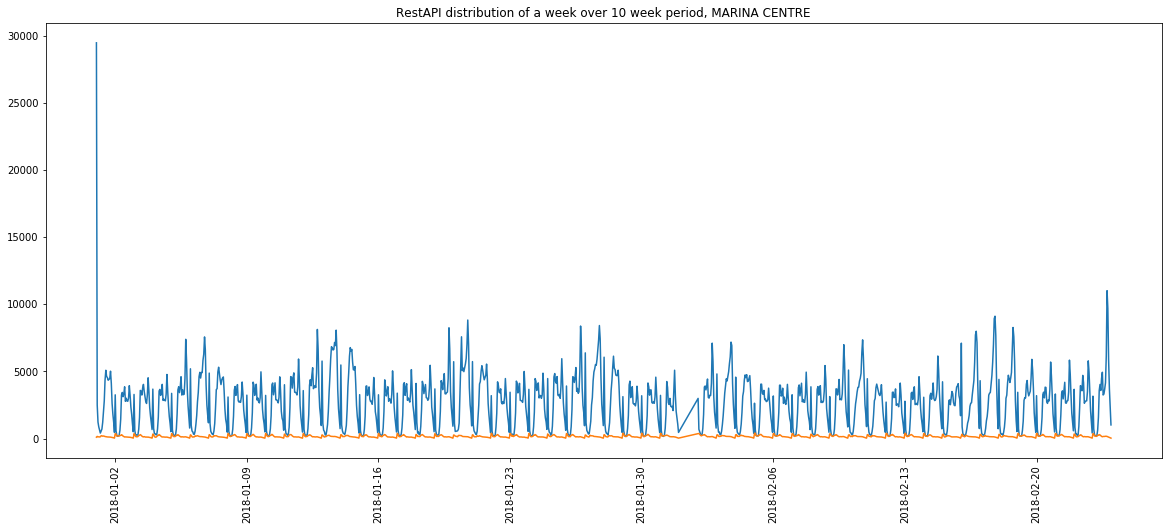

In [108]:
#Retrieve and plot a set of values
#Countdown 1 Jan, Chingay on 23 Feb, River hongbao on 17/18 Feb anomaly - DTSZ03
sample = df.loc[df['staypoint_subzone']== 'DTSZ03']
plt.figure(figsize=(20, 8))
plt.title("RestAPI distribution of a week over 10 week period, MARINA CENTRE")
plt.plot(sample['timestamp'], sample['total_stay'])
plt.plot(sample['timestamp'], sample['average_stay_duration'])
plt.xticks(rotation='vertical')

([<matplotlib.axis.XTick at 0x12461390>],
 <a list of 1 Text xticklabel objects>)

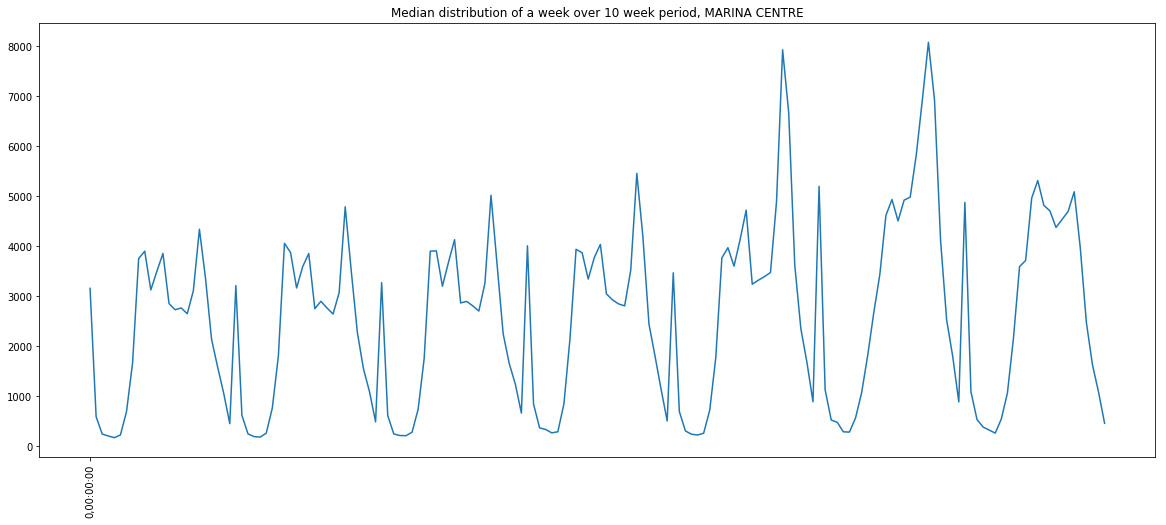

In [109]:
#Aggregate 10 week data into 1 week, using median.
week_hour_agg = df.groupby(['staypoint_subzone','time','day']).median().reset_index().sort_values(['day','time'])
#Median total stay for given subzone for ~8 weeks
agg_sample = week_hour_agg.loc[week_hour_agg['staypoint_subzone']== 'DTSZ03']
plt.figure(figsize=(20, 8))
plt.title("Median distribution of a week over 10 week period, MARINA CENTRE")
plt.plot([x+','+y for y,x in agg_sample[['time','day']].values], agg_sample['total_stay'])
plt.xticks(range(0,len(agg_sample),len(agg_sample)),rotation='vertical')

(array([736696., 736703., 736710., 736717., 736724., 736731., 736738.,
        736745.]), <a list of 8 Text xticklabel objects>)

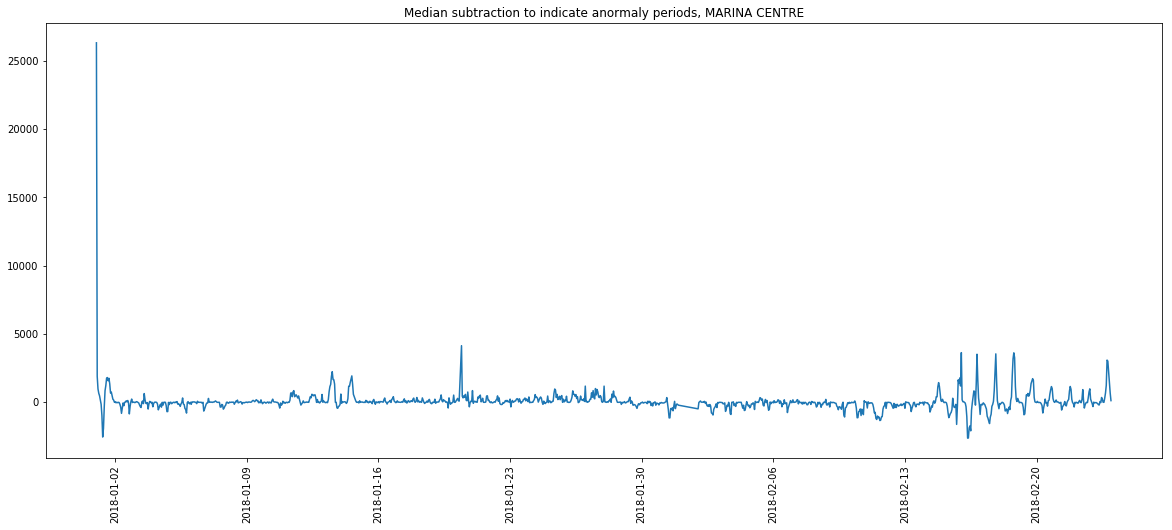

In [110]:
#Median Subtraction
df_medianreduce = df.merge(week_hour_agg,'left',['staypoint_subzone','time','day'])
df_medianreduce['total_stay_diff'] = df_medianreduce['total_stay_x'] - df_medianreduce['total_stay_y']
sample_diff = df_medianreduce.loc[df_medianreduce['staypoint_subzone']== 'DTSZ03']
plt.figure(figsize=(20, 8))
plt.title("Median subtraction to indicate anormaly periods, MARINA CENTRE")
plt.plot(sample_diff['timestamp'], sample_diff['total_stay_diff'])
plt.xticks(rotation='vertical')

(array([736696., 736703., 736710., 736717., 736724., 736731., 736738.,
        736745.]), <a list of 8 Text xticklabel objects>)

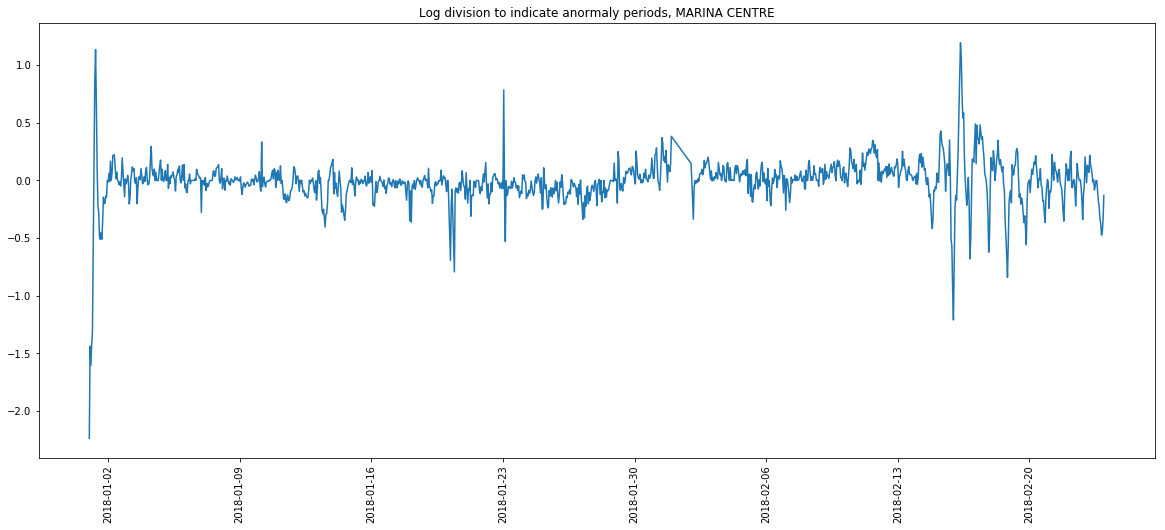

In [111]:
df_medianreduce['total_stay_log_divison'] = np.log(df_medianreduce['total_stay_y'] / df_medianreduce['total_stay_x'])
sample_log = df_medianreduce.loc[df_medianreduce['staypoint_subzone']== 'DTSZ03']
plt.figure(figsize=(20, 8))
plt.title("Log division to indicate anormaly periods, MARINA CENTRE")
plt.plot(sample_diff['timestamp'], sample_log['total_stay_log_divison'])
plt.xticks(rotation='vertical')

In [75]:
#Load back realtime datasets
allFiles = glob.glob(os.getcwd() + "/dataspark_realtime_*.csv")
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_, header=0)
    list_.append(df)
df_realtime = pd.concat(list_)
df_realtime['timestamp'] = df_realtime['timestamp'].map(lambda x: re.sub('T', ' ', x))
df_realtime['timestamp'] = df_realtime['timestamp'].map(lambda x: x.split("+")[0])


In [76]:
df_realtime['timestamp'] = df_realtime['timestamp'].astype('datetime64[ns]')
df_realtime = df_realtime.rename(columns={'subzone':'staypoint_subzone'})
df_realtime['timestamp'] = df_realtime['timestamp'].dt.round('60min')
df_realtime.insert(1,'time',df_realtime['timestamp'].dt.time.astype(str))
df_realtime.insert(2,'day',df_realtime['timestamp'].dt.dayofweek.astype(str))
df_realtime

,timestamp,time,day,staypoint_subzone,total_stay
0,2018-02-25 10:00:00,10:00:00,6,BDSZ08,4284
1,2018-02-25 10:00:00,10:00:00,6,BDSZ04,33592
2,2018-02-25 10:00:00,10:00:00,6,BDSZ02,6942
3,2018-02-25 10:00:00,10:00:00,6,BDSZ06,20531
4,2018-02-25 10:00:00,10:00:00,6,RCSZ09,4051
5,2018-02-25 10:00:00,10:00:00,6,KLSZ01,16081
6,2018-02-25 10:00:00,10:00:00,6,PNSZ03,3881
7,2018-02-25 10:00:00,10:00:00,6,TPSZ10,1332
8,2018-02-25 10:00:00,10:00:00,6,BSSZ03,15009
9,2018-02-25 10:00:00,10:00:00,6,SRSZ03,2206


In [77]:
df_realtime_red = df_realtime.merge(week_hour_agg,'left',['staypoint_subzone','time','day'])
df_realtime_red['total_stay_diff'] = df_realtime_red['total_stay_x'] - df_realtime_red['total_stay_y']
df_realtime_red['total_stay_log_divison'] = np.log(df_realtime_red['total_stay_y'] / df_realtime_red['total_stay_x'])
df_realtime_red

,timestamp,time,day,staypoint_subzone,total_stay_x,total_stay_y,total_stay_duration,average_stay_duration,total_stay_diff,total_stay_log_divison
0,2018-02-25 10:00:00,10:00:00,6,BDSZ08,4284,612.0,66586.0,108.800654,3672.0,-1.945910
1,2018-02-25 10:00:00,10:00:00,6,BDSZ04,33592,8394.0,1104920.0,130.744017,25198.0,-1.386771
2,2018-02-25 10:00:00,10:00:00,6,BDSZ02,6942,1092.0,140570.0,128.679903,5850.0,-1.849579
3,2018-02-25 10:00:00,10:00:00,6,BDSZ06,20531,4024.0,448272.0,107.396263,16507.0,-1.629660
4,2018-02-25 10:00:00,10:00:00,6,RCSZ09,4051,1265.0,217034.0,167.593822,2786.0,-1.163892
5,2018-02-25 10:00:00,10:00:00,6,KLSZ01,16081,2871.0,376626.0,127.429990,13210.0,-1.722978
6,2018-02-25 10:00:00,10:00:00,6,PNSZ03,3881,355.0,33655.0,88.801932,3526.0,-2.391730
7,2018-02-25 10:00:00,10:00:00,6,TPSZ10,1332,40.0,2305.0,57.625000,1292.0,-3.505557
8,2018-02-25 10:00:00,10:00:00,6,BSSZ03,15009,3968.0,456912.0,115.944526,11041.0,-1.330388
9,2018-02-25 10:00:00,10:00:00,6,SRSZ03,2206,624.0,101199.0,144.758853,1582.0,-1.262786


In [79]:
subzone_anomaly = pd.Series(df_realtime_red.total_stay_log_divison.values, index = df_realtime_red.staypoint_subzone).to_dict()
subzone_anomaly['max'] = np.nanmax(np.array(subzone_anomaly.values()))
subzone_anomaly['min'] = min(subzone_anomaly.values())

In [107]:
USR_DT = '2018-02-17 12:00:00'
compare_df = df.loc[df['timestamp'] == USR_DT]
compare_df = compare_df.merge(week_hour_agg,'left',['staypoint_subzone','time','day'])
compare_df['total_stay_diff'] = compare_df['total_stay_x'] - compare_df['total_stay_y']
compare_df['total_stay_log_divison'] = np.log(compare_df['total_stay_y'] / compare_df['total_stay_x'])
subzone_anomaly = pd.Series(compare_df.total_stay_log_divison.values, index = compare_df.staypoint_subzone).to_dict()
subzone_anomaly['max'] = np.nanmax(np.array(subzone_anomaly.values()))
subzone_anomaly['min'] = min(subzone_anomaly.values())
subzone_anomaly

{'AMSZ01': 0.6554371367944807,
 'AMSZ02': 0.053556104468962085,
 'AMSZ03': 0.0,
 'AMSZ04': -0.05115659833101887,
 'AMSZ05': -0.3350066444596029,
 'AMSZ06': -0.3458730109059187,
 'AMSZ07': -0.010794245130880512,
 'AMSZ08': -0.34488979474074233,
 'AMSZ09': -0.10384321484227371,
 'AMSZ10': 0.3445648751222204,
 'AMSZ11': 0.0,
 'AMSZ12': -0.014252022707201502,
 'BDSZ01': 0.052285449098074185,
 'BDSZ02': -0.09395001637504168,
 'BDSZ03': -0.08148217819703278,
 'BDSZ04': 0.06584953956214357,
 'BDSZ05': -0.13288751905904211,
 'BDSZ06': -0.03280497445292771,
 'BDSZ07': -0.6380874033769179,
 'BDSZ08': -0.2901232244923086,
 'BKSZ01': -0.01212136053234485,
 'BKSZ02': 0.08538668126262786,
 'BKSZ03': 0.11778303565638346,
 'BKSZ04': -0.0186572576045427,
 'BKSZ05': -0.275695627571413,
 'BKSZ06': 0.043270507265485626,
 'BKSZ07': 0.1018326281476178,
 'BKSZ08': -0.06313140282878371,
 'BKSZ09': 0.3033734022464565,
 'BLSZ01': 0.6804081547825156,
 'BLSZ02': 0.432956954365071,
 'BLSZ03': 1.1877122834541558,
 

In [ ]:
import json
from pprint import pprint

data = json.load(open('subzone.js'))
DTSZ03
pprint(data)